# Kinopoisk film parser

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests    
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from random import randrange
import time 
import socks
import socket
import resource
import sys
import re
import pickle
import itertools


import warnings
warnings.filterwarnings('ignore')


In [2]:
base_url = "http://kinopoisk.ru/top/navigator/m_act[ecountry]/20/m_act[rating]/1%3A/" 
# for search should be at least one filter, this one exludes Algeria and search all films with rating from 1 to 10
order_by = {"kinopoisk": "/order/rating", "imdb":"/order/ex_rating", "year":"/order/year"}

In [3]:
def get_link(order = "imdb", page = 1):
    return base_url + order_by[order] + "/page/{}/#results".format(page)

### Изменим порт, чтобы ip менялся (каждую секунду)

In [ ]:
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [4]:
def get_soup(link, agent = UserAgent().firefox, verbose=False):
    if verbose:
        print("Sending request: ", link)
    response = requests.get(link, headers={'User-Agent': agent})
    if not response.ok:
        return []
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    return soup

### Соберем страницы с фильмами

In [ ]:
soups = []
page_count = 510
block_count = 0
for i in tqdm_notebook(range(page_count)):
    time.sleep(randrange(5))
    soup = get_soup(get_link(page=i), agent = UserAgent().random)
    if 'captcha' in str(soup):
        for j in range(3):
            time.sleep(randrange(7))
            soup = get_soup(get_link(page=i), agent = UserAgent().random)
    if 'captcha' in str(soup):
        block_count = block_count + 1
        soup = None
        print("All request was blocked for page: ", i)
        time.sleep(20)
    soups.append(soup)

In [ ]:
print (sys.getrecursionlimit())
sys.setrecursionlimit(50000)

In [ ]:
file_path = 'file_path'

with open(file_path, 'wb') as f:
    pickle.dump(soups, f)

In [ ]:
filtered = [x for x in soups if x is not None]
len(filtered)

### Мы собрали информацию примерно 80% страниц фильмов, думаю должно быть достаточно. Теперь надо вытащить идентификаторы фильмов.

In [ ]:
film_ids = []
for soup in soups:
    if soup is None:
        continue 
    divs = soup.find_all('div', attrs={'class': "name"})
    for div in divs:
        film_ids.append(re.search('.*/film/(.*)/',div.a['href']).group(1))
        
film_ids[0:10:1][0]

In [ ]:
def get_film_link(id):
    return 'http://kinopoisk.ru/film/{}'.format(id)

In [ ]:
file_path = '/file_path'

with open(file_path, 'rb') as f:
    film_ids = pickle.load(f)

In [ ]:
get_soup(get_film_link(film_ids[0]), agent = UserAgent().random)

In [ ]:
def save_films(films, num_of_iter):
    file_path = 'file_path/models/filmsoups{}.pickle'.format(num_of_iter)
    with open(file_path, "wb") as f:
        pickle.dump(films, f)

### Запустим парсер и периодически будем снимать дамп с загруженными страницами

In [ ]:
film_soups = []
not_received = []
count = itertools.count(0)
dump_start = 0
dump_freq = 500

for film_id in tqdm_notebook(film_ids):
    try:
        time.sleep(1)
        film_soup = get_soup(get_film_link(film_id), agent = UserAgent().random)
        film_soups.append(film_soup)
        current_iter = next(count)
        if  current_iter % dump_freq == 0:
            print("Saving pack of films with number: {}", current_iter // dump_freq)
            save_films(film_soups[dump_start:dump_start + dump_freq], current_iter // dump_freq)
    except:
        print("Ooops!")

In [ ]:
films = len([x for x in film_soups if 'captcha' not in str(x)])

In [ ]:
films = []
for i in tqdm_notebook(range(32)):
    films.extend(film for film in get_films(i) if 'captcha' not in str(film))
films = len([x for x in film_soups if 'captcha' not in str(x)])

### Спустя два дня фильмы собраны, теперь пройдемся по всем файлам дампа, отфильтруем файлы с капчей и распарсим нужные поля (С капчей оказалось окло 70% страниц)

In [ ]:
def find_basic_info(soup, text, attr_name, film):
    tmp = soup.find('div',text=text)
    if tmp is not None:
        tmp = tmp.parent.select_one('div:nth-child(2n) a')
        if tmp is not None:
            film[attr_name] = tmp.text.replace(u'\xa0', u'')

def parse(soup):
    film = {}
    film_id = soup.select_one("meta[property='og:url']")
    if film_id is not None:
        film_id = re.search('.*/film/(.*)/',film_id['content'])
        if film_id is not None:
            film['id'] = int(film_id.group(1))
    
    name = soup.select_one('h1', attrs={'class*':'styles_title'})
    if name is not None:
        film['ru_name'] = name.span.text
        
    origin_name = soup.select_one("span[class*='styles_originalTitle']")
    if origin_name is not None:
        film['origin_name'] = origin_name.text
        
    basic_info_div = soup.select_one("div[class*='basicInfo']")
    basic_info_tuples = [("Год производства", 'make_year'), ("Страна", "country"), ("Жанр", 'genres'),
                        ('Слоган', 'Tagline'), ('Режиссер','director'), ('Сценарий', 'scriptwriter'),
                        ('Продюсер','producer'), ('Оператор','operator'), ('Композитор','music'),
                        ('Художник','artist'), ('Монтаж', 'edit'),('Бюджет','cost'), ('Маркетинг','marketing'),
                        ('Сборы в США','usa_fees'), ('Сборы в мире','world_fees'), ('Премьера в Росcии','rus_premiere'),
                        ('Премьера в мире','world_premiere'), ('Релиз на DVD', 'dvd_release')]
    
    if basic_info_div is not None:
        for text, attr_name in basic_info_tuples:
            find_basic_info(soup, text, attr_name, film)
    
    synopsis = soup.select_one("div[class*='styles_synopsis'] p ")
    if synopsis is not None:
        film['synopsis'] = synopsis.text
    
    kinopoisk_rating = soup.select_one('a.film-rating-value')
    if kinopoisk_rating is not None:
        film['kinopoisk_rating'] = kinopoisk_rating.text
    
    imdb_rating = soup.select_one("div.film-sub-rating > span[class*='value']")
    if imdb_rating is not None:
         film['imdb_rating'] = imdb_rating.text
            
    actors = soup.select_one("div.film-crew-block").select("div.film-crew-block > div > ul > li > a")
    if actors is not None and len(actors) != 0:
        film['first_5_actors'] = ",".join(actor_soup.text for actor_soup in actors[:5])
    return film

In [ ]:
def get_file_name(i):
    return 'file_path/models/filmsoups{}.pickle'.format(i)

def get_film_soups(num_of_file):
    soups = []
    all_soups = 0
    try:
        with open(get_file_name(num_of_file), "rb") as f:
            soups = pickle.load(f)
            all_soups = len(soups)
    except FileNotFoundError:
        print("File with i: {} not found", num_of_file)
    soups = [soup for soup in soups if 'captcha' not in str(soup)]
    print("Filtered {} of {} soups as captcha blocked".format((all_soups - len(soups)), all_soups))
    return soups

In [ ]:
# parsed_data = [] 
for i in tqdm_notebook(range(0, 32)):
    for soup in get_film_soups(i):
        try:
            parsed_data.append(parse(soup))
        except:
            print("Some error")

In [ ]:
file_path = 'file_path'
with open(file_path, "wb") as f:
    pickle.dump(parsed_data, f)

In [ ]:
file_path = '../models/parsed_films2.pickle'
with open(file_path, "rb") as f:
    parsed_data .extend( pickle.load(f))

### Страницы собраны в словари, теперь очистим его, удалим дубликаты, приведем к нужным типам данных и т.д.

In [ ]:
df = pd.DataFrame(parsed_data).drop_duplicates()
df

In [3]:
csv_path = "../csv/parsing/films.csv"
df.to_csv(csv_path)

In [4]:
df

,id,ru_name,origin_name,make_year,country,genres,director,scriptwriter,producer,operator,...,world_premiere,synopsis,kinopoisk_rating,imdb_rating,first_5_actors,cost,usa_fees,world_fees,rus_premiere,marketing
0.0,7620.0,С феями шутки плохи,Photographing Fairies,1997,Великобритания,фэнтези,Ник Уиллинг,Крис Харральд,Микеле Камарда,Джон де Борман,...,1997-09-19,Фотограф Чарльз Касл тяжело переживает утрату ...,6.256,6.8,"Тоби Стивенс,Эмили Вуф,Бен Кингсли,Фрэнсис Бар...",0.0,0.0,0.0,NaN,0.0
1.0,1035433.0,Скуби-Ду! На Диком Западе,Scooby-Doo! Shaggy's Showdown,2017,США,мультфильм,Мэтт Питерс,Кэнди Лангдэйл,Алан Барнетт,NaN,...,2017-02-14,Главные герои отправляются в уникальное место ...,6.264,6.8,"Фрэнк Уэлкер,Грэй Гриффин,Мэттью Лиллард,Кейт ...",0.0,0.0,0.0,NaN,0.0
2.0,804697.0,Оно,It Follows,2014,США,ужасы,Дэвид Роберт Митчелл,Дэвид Роберт Митчелл,Дэвид Каплан,Майк Гиулакис,...,2014-05-17,После сексуальной связи 19-летнюю девушку по и...,6.219,6.8,"Майка Монро,Кейр Гилкрист,Оливия Луккарди,Лили...",2000000.0,14674076.0,21729511.0,2015-06-25,0.0
3.0,95341.0,Салемские вампиры (ТВ),Salem's Lot,1979,США,ужасы,Тоуб Хупер,Пол Монаш,Анна Коттл,Джулс Бреннер,...,1979-11-17,"Бен Мейрс, успешный романист, возвращается дом...",6.199,6.8,"Дэвид Соул,Джеймс Мейсон,Лэнс Кервин,Бонни Бед...",4000000.0,0.0,0.0,NaN,0.0
4.0,711424.0,Глория,Gloria,2013,Чили,драма,Себастьян Лелио,Себастьян Лелио,Луис Кольяр,Бенхамин Эчасаррета,...,2013-02-10,58-летняя разведенная женщина начинает скучать...,6.160,6.8,"Паулина Гарсиа,Серхио Эрнандес,Диего Фонтесиль...",0.0,2107925.0,6461559.0,2014-04-17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781.0,8160.0,Аэропорт,Airport,1970,США,боевик,Джордж Ситон,Джордж Ситон,Росс Хантер,Эрнест Ласло,...,1970-03-05,"Похоже, что начальнику Международного Аэропорт...",7.127,6.6,"Берт Ланкастер,Дин Мартин,Джин Сиберг,Жаклин Б...",10000000.0,100489151.0,100489151.0,NaN,0.0
22782.0,760740.0,Макбет,Macbeth,2015,Великобритания,драма,Джастин Курзель,Тодд Луисо,Эйн Каннинг,Адам Аркпоу,...,2015-05-23,"Холодные поля Шотландии, военный лагерь, всегд...",7.117,6.6,"Майкл Фассбендер,Марион Котийяр,Пэдди Консидай...",15000000.0,1110707.0,16322067.0,2015-11-26,0.0
22783.0,493222.0,На грани,Man on a Ledge,2012,США,триллер,Асгер Лет,Пабло Ф. Фенхвес,Лоренцо Ди Бонавентура,Пол Кэмерон,...,2012-01-26,"Экс-полицейский, обвиняемый в преступлении, ко...",7.108,6.6,"Сэм Уортингтон,Элизабет Бэнкс,Джейми Белл,Джен...",42000000.0,18620000.0,47636031.0,2012-02-02,0.0
22784.0,271999.0,Запретное царство,The Forbidden Kingdom,2008,США,фэнтези,Роб Минкофф,Джон Фуско,Кэйси Сильвер,Питер Пау,...,2008-04-04,"Американский подросток Джейсон, основательно п...",7.097,6.6,"Джет Ли,Джеки Чан,Майкл Ангарано,Хуана Коллинь...",55000000.0,52075270.0,127980002.0,2008-04-24,0.0


### Наконец-то мы собрали наш датасет, теперь надо его обработать, привести к нормальным значениям и т.д.

In [ ]:
df['kinopoisk_rating'] = df['kinopoisk_rating'].astype(float)

In [ ]:
df['imdb_rating'].unique()

In [ ]:
df['imdb_rating'] = df['imdb_rating'].astype(str).apply(lambda x: x.split()[1] if x != 'nan' else 0).astype(float)

In [ ]:
def to_numeric(string):
    if "=" in string:
        string = string[string.find('='):]
    return 0 if string == 'nan' else ''.join(c for c in string if c.isdigit())

In [ ]:
df['cost'] = df['cost'].astype(str).apply(to_numeric).astype('int32')

In [ ]:
df['id'] = df['id'].replace(np.nan, 0).astype('int32')

In [ ]:
df['make_year'] = df['make_year'].astype('int32')

In [ ]:
df['usa_fees'] = df['usa_fees'].astype(str).apply(to_numeric).astype('int32')

In [ ]:
df['world_fees'] = df['world_fees'].astype(str).apply(to_numeric).astype('int32')

In [ ]:
df['marketing'] = df['marketing'].astype(str).apply(to_numeric).astype('int32')

<AxesSubplot:xlabel='make_year', ylabel='imdb_rating'>

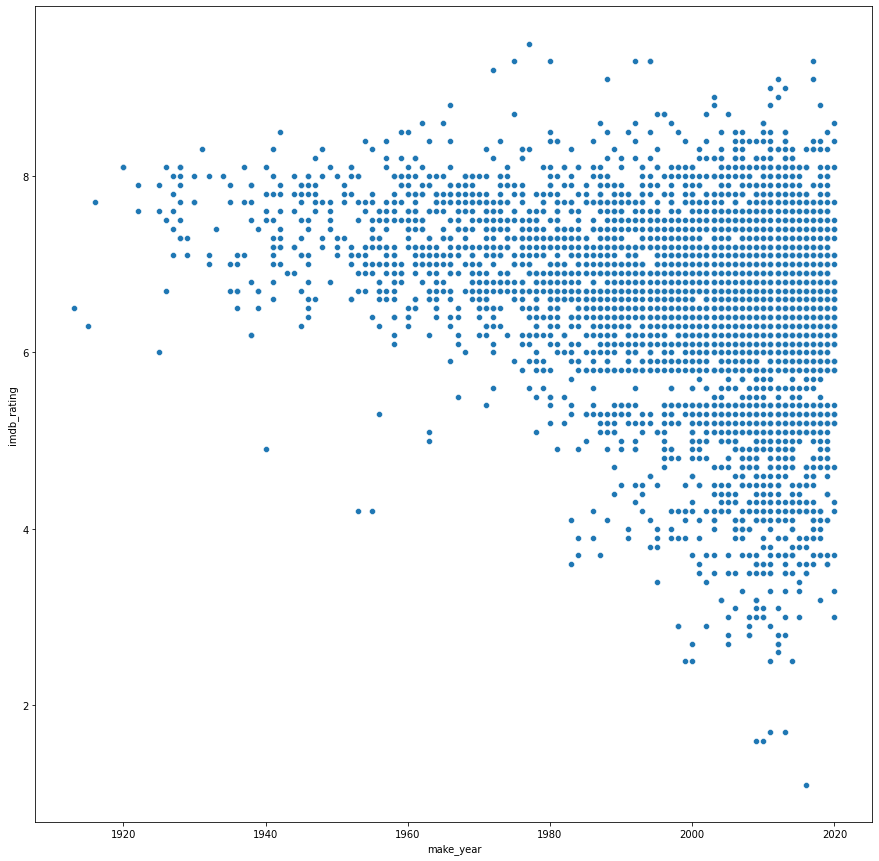

In [6]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=df, y='imdb_rating', x='make_year')

### Отличная иллюстрация фразы "Раньше было лучше"

In [7]:
df

,id,ru_name,origin_name,make_year,country,genres,director,scriptwriter,producer,operator,...,world_premiere,synopsis,kinopoisk_rating,imdb_rating,first_5_actors,cost,usa_fees,world_fees,rus_premiere,marketing
0.0,7620.0,С феями шутки плохи,Photographing Fairies,1997,Великобритания,фэнтези,Ник Уиллинг,Крис Харральд,Микеле Камарда,Джон де Борман,...,1997-09-19,Фотограф Чарльз Касл тяжело переживает утрату ...,6.256,6.8,"Тоби Стивенс,Эмили Вуф,Бен Кингсли,Фрэнсис Бар...",0.0,0.0,0.0,NaN,0.0
1.0,1035433.0,Скуби-Ду! На Диком Западе,Scooby-Doo! Shaggy's Showdown,2017,США,мультфильм,Мэтт Питерс,Кэнди Лангдэйл,Алан Барнетт,NaN,...,2017-02-14,Главные герои отправляются в уникальное место ...,6.264,6.8,"Фрэнк Уэлкер,Грэй Гриффин,Мэттью Лиллард,Кейт ...",0.0,0.0,0.0,NaN,0.0
2.0,804697.0,Оно,It Follows,2014,США,ужасы,Дэвид Роберт Митчелл,Дэвид Роберт Митчелл,Дэвид Каплан,Майк Гиулакис,...,2014-05-17,После сексуальной связи 19-летнюю девушку по и...,6.219,6.8,"Майка Монро,Кейр Гилкрист,Оливия Луккарди,Лили...",2000000.0,14674076.0,21729511.0,2015-06-25,0.0
3.0,95341.0,Салемские вампиры (ТВ),Salem's Lot,1979,США,ужасы,Тоуб Хупер,Пол Монаш,Анна Коттл,Джулс Бреннер,...,1979-11-17,"Бен Мейрс, успешный романист, возвращается дом...",6.199,6.8,"Дэвид Соул,Джеймс Мейсон,Лэнс Кервин,Бонни Бед...",4000000.0,0.0,0.0,NaN,0.0
4.0,711424.0,Глория,Gloria,2013,Чили,драма,Себастьян Лелио,Себастьян Лелио,Луис Кольяр,Бенхамин Эчасаррета,...,2013-02-10,58-летняя разведенная женщина начинает скучать...,6.160,6.8,"Паулина Гарсиа,Серхио Эрнандес,Диего Фонтесиль...",0.0,2107925.0,6461559.0,2014-04-17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781.0,8160.0,Аэропорт,Airport,1970,США,боевик,Джордж Ситон,Джордж Ситон,Росс Хантер,Эрнест Ласло,...,1970-03-05,"Похоже, что начальнику Международного Аэропорт...",7.127,6.6,"Берт Ланкастер,Дин Мартин,Джин Сиберг,Жаклин Б...",10000000.0,100489151.0,100489151.0,NaN,0.0
22782.0,760740.0,Макбет,Macbeth,2015,Великобритания,драма,Джастин Курзель,Тодд Луисо,Эйн Каннинг,Адам Аркпоу,...,2015-05-23,"Холодные поля Шотландии, военный лагерь, всегд...",7.117,6.6,"Майкл Фассбендер,Марион Котийяр,Пэдди Консидай...",15000000.0,1110707.0,16322067.0,2015-11-26,0.0
22783.0,493222.0,На грани,Man on a Ledge,2012,США,триллер,Асгер Лет,Пабло Ф. Фенхвес,Лоренцо Ди Бонавентура,Пол Кэмерон,...,2012-01-26,"Экс-полицейский, обвиняемый в преступлении, ко...",7.108,6.6,"Сэм Уортингтон,Элизабет Бэнкс,Джейми Белл,Джен...",42000000.0,18620000.0,47636031.0,2012-02-02,0.0
22784.0,271999.0,Запретное царство,The Forbidden Kingdom,2008,США,фэнтези,Роб Минкофф,Джон Фуско,Кэйси Сильвер,Питер Пау,...,2008-04-04,"Американский подросток Джейсон, основательно п...",7.097,6.6,"Джет Ли,Джеки Чан,Майкл Ангарано,Хуана Коллинь...",55000000.0,52075270.0,127980002.0,2008-04-24,0.0


<AxesSubplot:xlabel='imdb_rating', ylabel='kinopoisk_rating'>

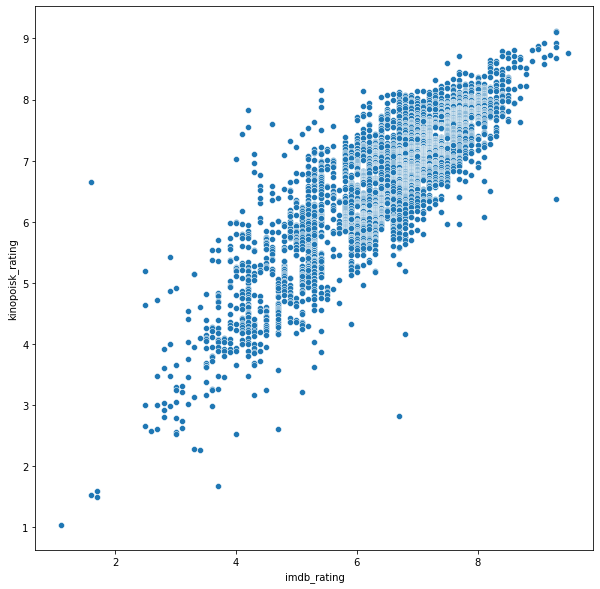

In [8]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, y='kinopoisk_rating', x='imdb_rating')

### Два рейтинга сильно скоррелированы, так что стоит выбрать один как целевую переменную, а второй выложить из датасета

In [9]:
import pymorphy2
from datetime import date

morph = pymorphy2.MorphAnalyzer()
months = dict(zip(['январь',"февраль","март","апрель","май","июнь","июль","август","сентябрь","октябрь","ноябрь","декабрь"], range(1,13)))
def to_date(string):
    if string == 'nan':
        return string
    res = []
    for substr in string.split():
        norm = morph.normal_forms(substr)[0]
        if norm in months.keys():
            res.append(int(months[norm]))
        else:
            res.append(int(substr))
    if len(res) != 3:
        return 'nan'
    return date(year=res[2], month=res[1],day=res[0])

In [ ]:
df['world_premiere'] = df['world_premiere'].astype(str).apply(to_datpd.e)

In [ ]:
df['world_premiere'] = pd.to_datetime(df['world_premiere'])

In [ ]:
df['rus_premiere']= df['rus_premiere'].astype(str).apply(to_date)

In [ ]:
df['rus_premiere'] = pd.to_datetime(df['rus_premiere'])

In [16]:
df['marketing'].fillna(0,inplace=True)

In [15]:
df['cost'].fillna(df['cost'].mean(),inplace=True)

In [14]:
df['usa_fees'].fillna(0,inplace=True)

In [13]:
df['world_fees'].fillna(0,inplace=True)

In [24]:
df = df[~df['imdb_rating'].isna()]

In [25]:
df = df[~df['kinopoisk_rating'].isna()]

In [293]:
csv_path = "../csv/parsing/films_cleaned.csv"
# df.to_csv(csv_path)
df = pd.read_csv(csv_path,index_col=0) 

### Данные очищены. Можно строить модели

In [295]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def show_metrics(model, X_train, X_test, y_train, y_test):
    print("R2 на обучающем наборе: {:.2f}".format(model.score(X_train, y_train)))
    print("R2 на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
    print("MAE: {:.2f}".format(mean_absolute_error(y_test, model.predict(X_test))))
    print("MSE: {:.2f}".format(mean_squared_error(y_test, model.predict(X_test))))

In [296]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

le = preprocessing.LabelEncoder()
scaler = preprocessing.StandardScaler()
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_depth=7)

df['dir_encoded'] = le.fit_transform(df['director'].values.astype(str))
df['scriptwriter_encoded'] = le.fit_transform(df['scriptwriter'].values.astype(str))
df['producer_encoded'] = le.fit_transform(df['producer'].values.astype(str))
df['operator_encoded'] = le.fit_transform(df['operator'].values.astype(str))
df['music_encoded'] = le.fit_transform(df['music'].values.astype(str))
df['artist_encoded'] = le.fit_transform(df['artist'].values.astype(str))
df['edit_enc'] = le.fit_transform(df['edit'].values.astype(str))
df['genres_enc'] = le.fit_transform(df['genres'].values.astype(str))
df['country_enc'] = le.fit_transform(df['country'].values.astype(str))


y = df['imdb_rating']
to_drop = ['imdb_rating', 'kinopoisk_rating','ru_name', 'origin_name', 'id', 'first_5_actors','synopsis',
          'director', 'scriptwriter', 'producer', 'operator','music','artist','edit','genres','country', 
           'world_premiere', 'synopsis', 'kinopoisk_rating', 'imdb_rating', 'rus_premiere']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=to_drop), y, test_size=0.33,
                                                        random_state=42)

pipe = Pipeline([
    ('scaler',scaler),
    ('regressor', rf)
])

pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.48
R2 на тестовом наборе: 0.31
MAE: 0.65
MSE: 0.74


<AxesSubplot:>

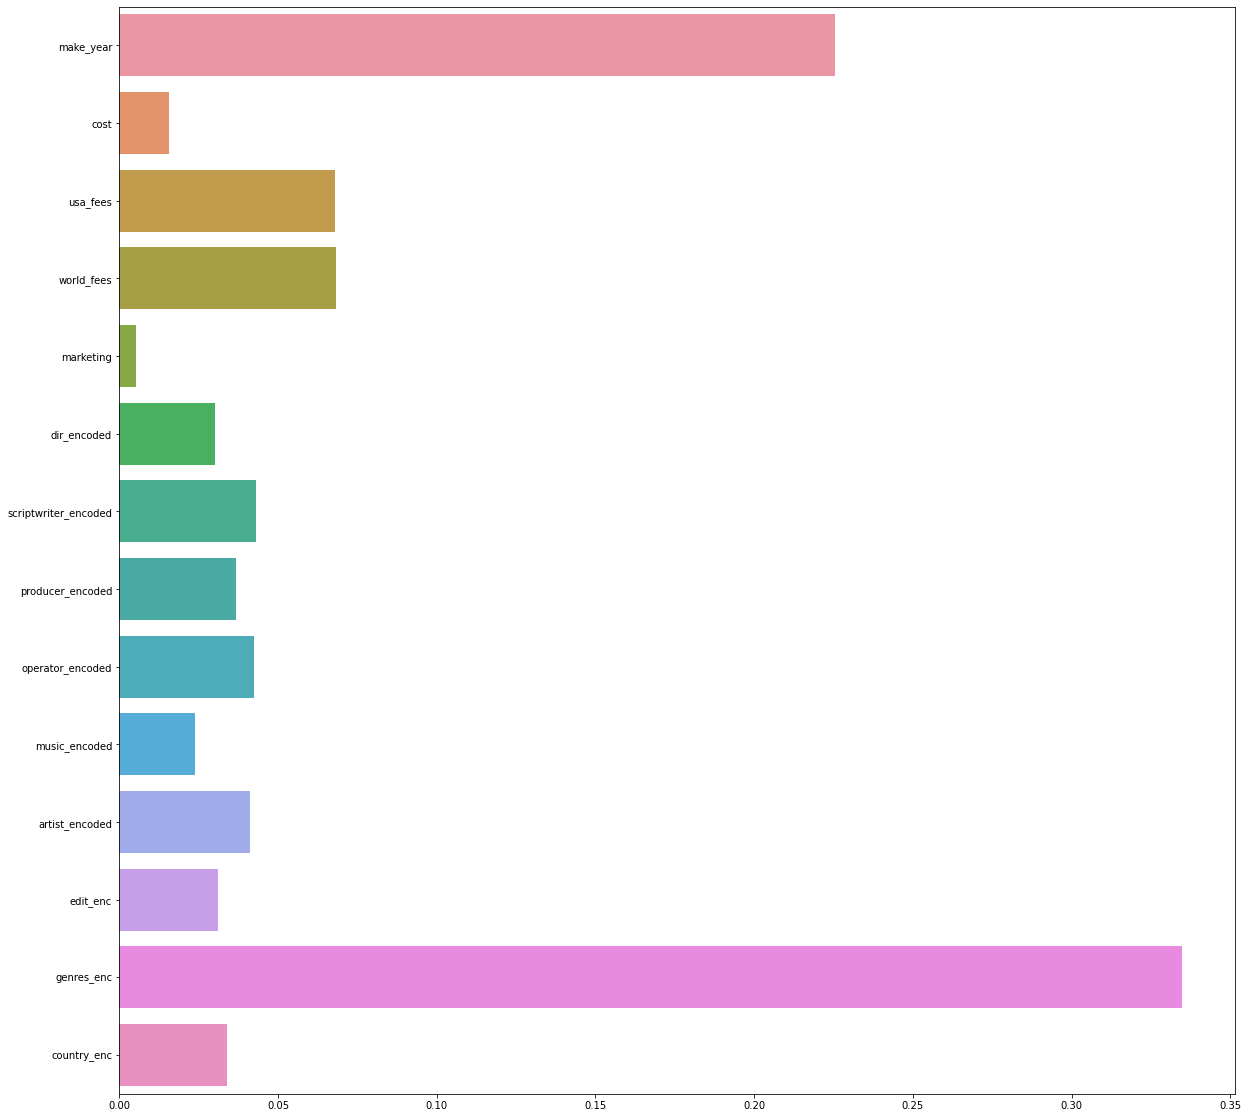

In [297]:
plt.figure(figsize=(20, 20))
sns.barplot(x=rf.feature_importances_, y = X_train.columns)

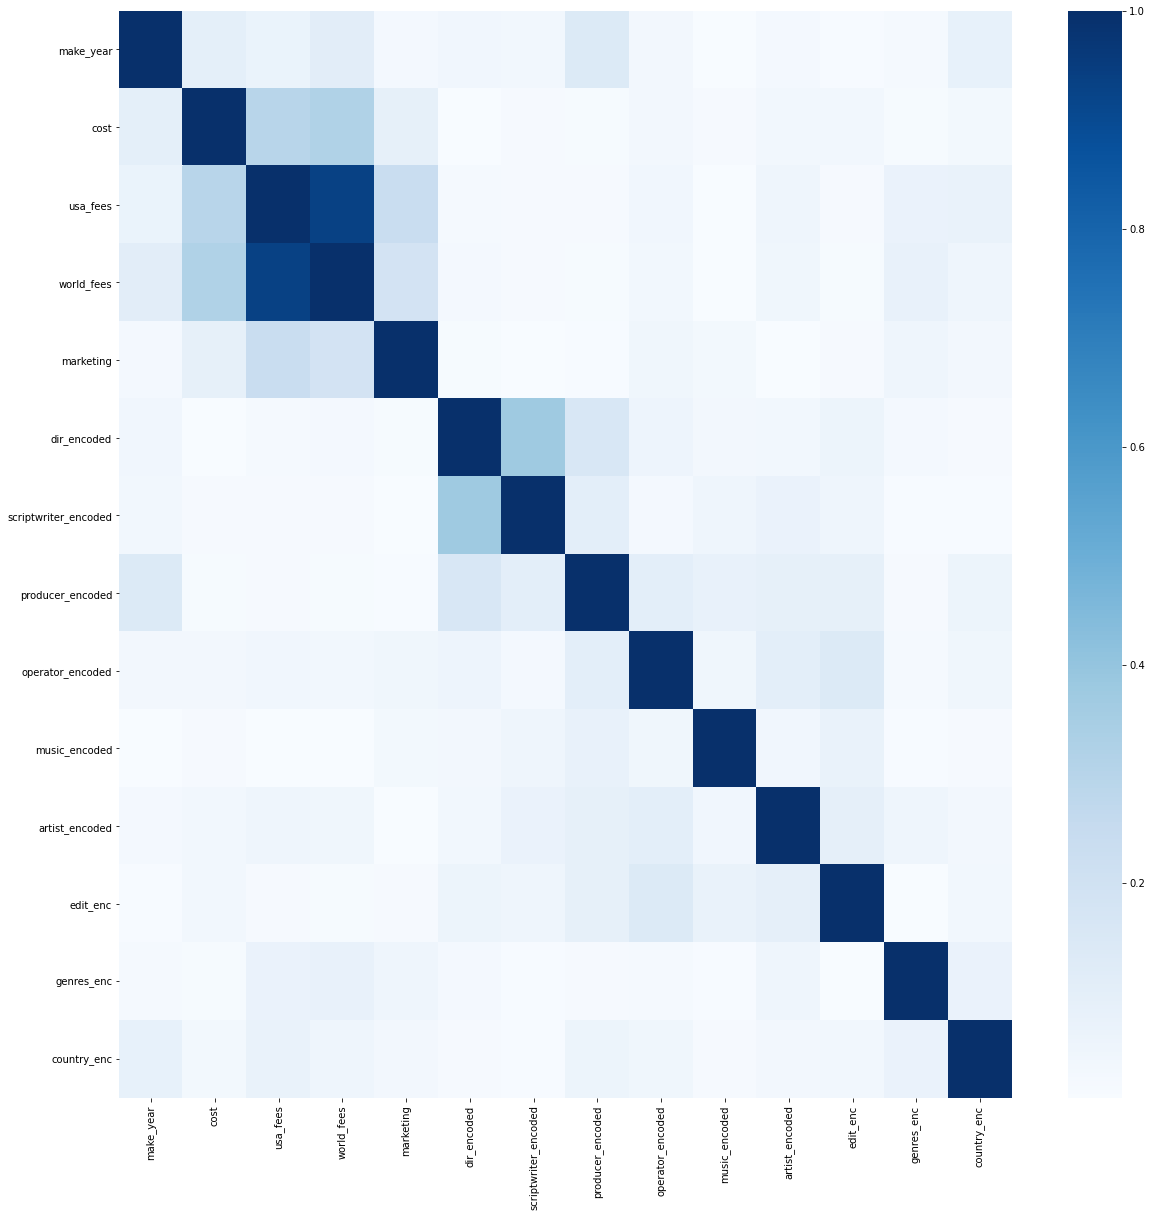

In [298]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.drop(to_drop, axis=1).corr().abs(), cmap='Blues')
plt.show()

### Попробуем OneHot, возможно какие-то режиссеры,продюсеры или сценаристы больше влияют на результат

In [299]:
ds = df.copy()

In [300]:
ds = pd.get_dummies(ds, prefix='dir_', columns=['director'],drop_first=True)
ds = pd.get_dummies(ds, prefix='prod_', columns=['producer'],drop_first=True)

In [301]:
ds = pd.get_dummies(ds, prefix='op_', columns=['operator'],drop_first=True)
ds = pd.get_dummies(ds, prefix='script_', columns=['scriptwriter'],drop_first=True)

In [302]:
scaler = preprocessing.StandardScaler()
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=10)



y = df['imdb_rating']
to_drop = ['imdb_rating', 'kinopoisk_rating','ru_name', 'origin_name', 'id', 'first_5_actors','synopsis',
    'music','artist','edit','genres','country', 'world_premiere', 'synopsis', 'kinopoisk_rating', 'imdb_rating',
        'rus_premiere',]

X_train, X_test, y_train, y_test = train_test_split(ds.drop(columns=to_drop), y, test_size=0.33,
                                                        random_state=42)

pipe = Pipeline([
    ('scaler',scaler),
    ('regressor', rf)
])

pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.60
R2 на тестовом наборе: 0.33
MAE: 0.64
MSE: 0.72


In [15]:
ds.shape

(4910, 12921)

### Почти тот же результат, но слишком уж большая размерность

### Попробуем линейные модели и бустинг

In [303]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

y = df['imdb_rating']
to_drop = ['imdb_rating', 'kinopoisk_rating','ru_name', 'origin_name', 'id', 'first_5_actors','synopsis',
          'director', 'scriptwriter', 'producer', 'operator','music','artist','edit','genres','country', 'world_premiere', 'synopsis', 'kinopoisk_rating', 'imdb_rating',
        'rus_premiere',]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=to_drop), y, test_size=0.33,
                                                        random_state=42)

poly = PolynomialFeatures(2)
scaler = preprocessing.StandardScaler()
ridge = LassoCV()
pipe = Pipeline([('poly', poly),('scaler', scaler), ('ridge', ridge)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.19
R2 на тестовом наборе: 0.18
MAE: 0.71
MSE: 0.89


In [304]:
from sklearn.svm import SVR

svr = SVR()
pipe = Pipeline([('scaler', scaler), ('svr', svr)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.29
R2 на тестовом наборе: 0.17
MAE: 0.70
MSE: 0.89


In [305]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(max_depth=3)
cat.fit(X_train, y_train, silent=True)
show_metrics(cat, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.51
R2 на тестовом наборе: 0.35
MAE: 0.63
MSE: 0.70


### Довольно неплохие показатели, попробуем их улучшить с помощью описания, так же можно добавить актеров

In [306]:
df['first_5_actors']

0.0        Тоби Стивенс,Эмили Вуф,Бен Кингсли,Фрэнсис Бар...
1.0        Фрэнк Уэлкер,Грэй Гриффин,Мэттью Лиллард,Кейт ...
2.0        Майка Монро,Кейр Гилкрист,Оливия Луккарди,Лили...
3.0        Дэвид Соул,Джеймс Мейсон,Лэнс Кервин,Бонни Бед...
4.0        Паулина Гарсиа,Серхио Эрнандес,Диего Фонтесиль...
                                 ...                        
22781.0    Берт Ланкастер,Дин Мартин,Джин Сиберг,Жаклин Б...
22782.0    Майкл Фассбендер,Марион Котийяр,Пэдди Консидай...
22783.0    Сэм Уортингтон,Элизабет Бэнкс,Джейми Белл,Джен...
22784.0    Джет Ли,Джеки Чан,Майкл Ангарано,Хуана Коллинь...
22788.0    Жан Рено,Анна Гальена,Хлоя Дез,Юго Дессью,Ор А...
Name: first_5_actors, Length: 4910, dtype: object

In [307]:
def split(row):
    if not row or row == 'nan':
        return np.zeros(5)
    return row.split(',')

In [308]:
splited = df['first_5_actors'].astype(str).apply(split)
for i in range(5):
    column_name = 'actor_{}'.format(i+1)
    df[column_name] = np.array([x[i] if len(x) == 5 else np.nan for x in splited])

In [309]:
df

,id,ru_name,origin_name,make_year,country,genres,director,scriptwriter,producer,operator,...,music_encoded,artist_encoded,edit_enc,genres_enc,country_enc,actor_1,actor_2,actor_3,actor_4,actor_5
0.0,7620.0,С феями шутки плохи,Photographing Fairies,1997,Великобритания,фэнтези,Ник Уиллинг,Крис Харральд,Микеле Камарда,Джон де Борман,...,1757,1294,2550,28,10,Тоби Стивенс,Эмили Вуф,Бен Кингсли,Фрэнсис Барбер,Филип Дэвис
1.0,1035433.0,Скуби-Ду! На Диком Западе,Scooby-Doo! Shaggy's Showdown,2017,США,мультфильм,Мэтт Питерс,Кэнди Лангдэйл,Алан Барнетт,NaN,...,1135,62,2152,17,54,Фрэнк Уэлкер,Грэй Гриффин,Мэттью Лиллард,Кейт Микуччи,Карлос Аласраки
2.0,804697.0,Оно,It Follows,2014,США,ужасы,Дэвид Роберт Митчелл,Дэвид Роберт Митчелл,Дэвид Каплан,Майк Гиулакис,...,1674,1341,2504,25,54,Майка Монро,Кейр Гилкрист,Оливия Луккарди,Лили Сепе,Дэниэл Дзоватто
3.0,95341.0,Салемские вампиры (ТВ),Salem's Lot,1979,США,ужасы,Тоуб Хупер,Пол Монаш,Анна Коттл,Джулс Бреннер,...,501,1530,2306,25,54,Дэвид Соул,Джеймс Мейсон,Лэнс Кервин,Бонни Беделиа,Лью Эйрз
4.0,711424.0,Глория,Gloria,2013,Чили,драма,Себастьян Лелио,Себастьян Лелио,Луис Кольяр,Бенхамин Эчасаррета,...,105,1444,2059,9,69,Паулина Гарсиа,Серхио Эрнандес,Диего Фонтесилья,Фабиола Самора,Луз Хименез
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781.0,8160.0,Аэропорт,Airport,1970,США,боевик,Джордж Ситон,Джордж Ситон,Росс Хантер,Эрнест Ласло,...,217,876,2193,2,54,Берт Ланкастер,Дин Мартин,Джин Сиберг,Жаклин Биссет,Джордж Кеннеди
22782.0,760740.0,Макбет,Macbeth,2015,Великобритания,драма,Джастин Курзель,Тодд Луисо,Эйн Каннинг,Адам Аркпоу,...,602,2309,1165,9,10,Майкл Фассбендер,Марион Котийяр,Пэдди Консидайн,Шон Харрис,Джек Рейнор
22783.0,493222.0,На грани,Man on a Ledge,2012,США,триллер,Асгер Лет,Пабло Ф. Фенхвес,Лоренцо Ди Бонавентура,Пол Кэмерон,...,514,96,1081,24,54,Сэм Уортингтон,Элизабет Бэнкс,Джейми Белл,Дженезис Родригез,Эд Харрис
22784.0,271999.0,Запретное царство,The Forbidden Kingdom,2008,США,фэнтези,Роб Минкофф,Джон Фуско,Кэйси Сильвер,Питер Пау,...,836,296,2660,28,54,Джет Ли,Джеки Чан,Майкл Ангарано,Хуана Коллиньон,Морган Бенуа


In [310]:
le = preprocessing.LabelEncoder()

for i in range(5):
    column_name = 'enc_actor_{}'.format(i+1)
    df[column_name] = le.fit_transform(df['actor_{}'.format(i+1)].values.astype(str))

In [311]:
df.columns

Index(['id', 'ru_name', 'origin_name', 'make_year', 'country', 'genres',
       'director', 'scriptwriter', 'producer', 'operator', 'music', 'artist',
       'edit', 'world_premiere', 'synopsis', 'kinopoisk_rating', 'imdb_rating',
       'first_5_actors', 'cost', 'usa_fees', 'world_fees', 'rus_premiere',
       'marketing', 'dir_encoded', 'scriptwriter_encoded', 'producer_encoded',
       'operator_encoded', 'music_encoded', 'artist_encoded', 'edit_enc',
       'genres_enc', 'country_enc', 'actor_1', 'actor_2', 'actor_3', 'actor_4',
       'actor_5', 'enc_actor_1', 'enc_actor_2', 'enc_actor_3', 'enc_actor_4',
       'enc_actor_5'],
      dtype='object')

In [312]:
y = df['imdb_rating']
to_drop = ['imdb_rating', 'kinopoisk_rating','ru_name', 'origin_name', 'id', 'first_5_actors','synopsis',
          'director', 'scriptwriter', 'producer', 'operator','music','artist','edit','genres','country', 
           'world_premiere', 'synopsis', 'kinopoisk_rating', 'imdb_rating', 'rus_premiere','actor_1', 
         'actor_2', 'actor_3', 'actor_4', 'actor_5']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=to_drop), y, test_size=0.33,
                                                        random_state=42)

cat = CatBoostRegressor(max_depth=3)
cat.fit(X_train, y_train, silent=True)
show_metrics(cat, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.54
R2 на тестовом наборе: 0.33
MAE: 0.64
MSE: 0.72


### Не очень помогло, нужен другой подход. Попробуем найти 500 самых популярный актеров, и создадим признак, где будем проставлять наличие известного актера. А лучше количество известных актеров.

In [313]:
df.drop(columns=['actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'enc_actor_1', 'enc_actor_2', 'enc_actor_3',
       'enc_actor_4', 'enc_actor_5'], inplace=True)

In [314]:
actors = []
for lst in itertools.chain(df['first_5_actors'].astype(str).apply(split).values):
    actors.extend(lst)

In [315]:
from nltk import ngrams, FreqDist
import itertools

actor_freq = FreqDist(actors)

In [316]:
actor_freq.most_common(26)[0:]

[(0.0, 55),
 ('Роберт Де Ниро', 22),
 ('Сэмюэл Л. Джексон', 20),
 ('Сильвестр Сталлоне', 19),
 ('Дастин Хоффман', 18),
 ('Энтони Хопкинс', 17),
 ('Джеки Чан', 17),
 ('Итан Хоук', 16),
 ('Джулия Робертс', 16),
 ('Морган Фриман', 16),
 ('Вуди Харрельсон', 16),
 ('Алек Болдуин', 16),
 ('Кристиан Слэйтер', 16),
 ('Аль Пачино', 16),
 ('Питер Фальк', 16),
 ('Киану Ривз', 15),
 ('Мишель Пфайффер', 15),
 ('Джулианна Мур', 15),
 ('Харрисон Форд', 15),
 ('Бен Кингсли', 14),
 ('Джек Николсон', 14),
 ('Мэтт Дэймон', 14),
 ('Николь Кидман', 14),
 ('Гари Олдман', 14),
 ('Брюс Уиллис', 14),
 ('Уиллем Дефо', 14)]

### Интересно получается. Можно взять количество фильмов с актером за "вес" актера и просуммировать для каждого фильма

In [321]:
def actors_sum(current_actors):
    actors = current_actors.split(',')
    if not actors:
        return 0
    act_sum = 0
    for actor in actors:
        if actor == '0.0':
            continue
        else:
            act_sum = act_sum + actor_freq[actor]
    return act_sum    

In [322]:
df['actors_sum'] = df['first_5_actors'].astype(str).apply(actors_sum)

In [323]:
df[df['actors_sum'] > 50]

,id,ru_name,origin_name,make_year,country,genres,director,scriptwriter,producer,operator,...,dir_encoded,scriptwriter_encoded,producer_encoded,operator_encoded,music_encoded,artist_encoded,edit_enc,genres_enc,country_enc,actors_sum
328.0,501821.0,Заражение,Contagion,2011,ОАЭ,боевик,Стивен Содерберг,Скотт З. Бёрнс,Грегори Джейкобс,Стивен Содерберг,...,2725,2929,612,1952,1081,2406,2169,2,45,53
352.0,81503.0,Компаньоны,A Prairie Home Companion,2006,США,мюзикл,Роберт Олтмен,Гаррисон Кейллор,Роберт Олтмен,Эдвард Лахман,...,2453,624,2348,2306,504,796,545,18,54,55
394.0,4517.0,Эпидемия,Outbreak,1995,США,триллер,Вольфганг Петерсен,Лоуренс Дуорет,Гэйл Кац,Михаэль Балльхаус,...,528,1895,631,1474,617,2262,2368,24,54,56
786.0,854942.0,Джейсон Борн,Jason Bourne,2016,США,боевик,Пол Гринграсс,Пол Гринграсс,Мэтт Дэймон,Бэрри Экройд,...,2294,2532,1981,382,836,1750,1208,2,54,53
824.0,18294.0,Двенадцать друзей Оушена,Ocean's Twelve,2004,США,триллер,Стивен Содерберг,Джордж Нолфи,Брюс Берман,Стивен Содерберг,...,2725,1111,456,1952,874,2303,2169,24,54,54
1276.0,632.0,В чужом ряду,Changing Lanes,2002,США,триллер,Роджер Мишелл,Чэп Тейлор,Скотт Рудин,Сальваторе Тотино,...,2480,3510,2538,1847,835,1162,1210,24,54,53
2006.0,543838.0,Забойный реванш,Grudge Match,2013,США,драма,Питер Сигал,Тим Келлехер,Майкл Юинг,Дин Семлер,...,2276,3120,1729,817,1969,413,2361,9,54,54
2924.0,61439.0,Знакомство с Факерами,Meet the Fockers,2004,США,мелодрама,Джей Роуч,Джим Херцфелд,Роберт Де Ниро,Джон Шварцман,...,728,960,2331,776,1751,1799,96,15,54,59
2949.0,682669.0,Малавита,The Family,2013,Франция,криминал,Люк Бессон,Люк Бессон,Джейсон Бекман,Тьерри Арбогаст,...,1753,1927,733,2080,908,2621,959,14,65,53
2988.0,568355.0,Тайна в их глазах,Secret in Their Eyes,2015,США,триллер,Билли Рэй,Билли Рэй,Мэтт Джексон,Дэниэл Модер,...,350,400,1979,908,2206,1576,637,24,54,52


<AxesSubplot:xlabel='actors_sum', ylabel='imdb_rating'>

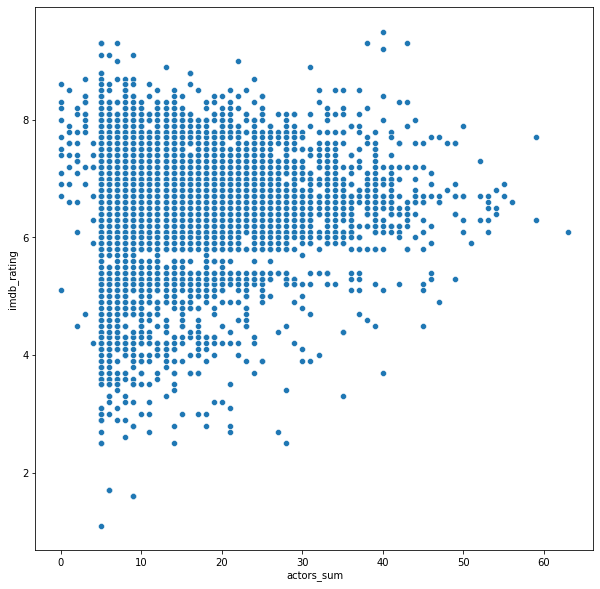

In [324]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, y='imdb_rating', x='actors_sum')

### Ну, что-то немного похожее на линейную зависимость

<AxesSubplot:xlabel='imdb_rating', ylabel='actors_sum'>

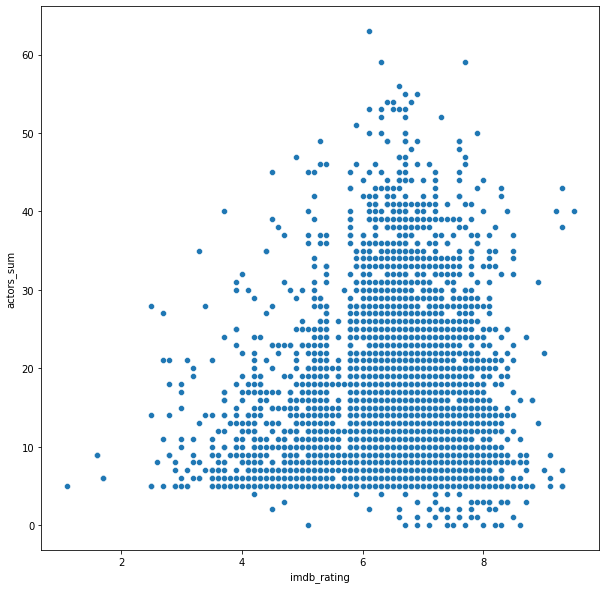

In [325]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, y='actors_sum', x='imdb_rating')

In [361]:
df.drop(columns=to_drop)

,make_year,cost,usa_fees,world_fees,marketing,dir_encoded,scriptwriter_encoded,producer_encoded,operator_encoded,music_encoded,artist_encoded,edit_enc,genres_enc,country_enc,actors_sum,synopsis_norm
0.0,1997,0.0,0.0,0.0,0.0,2093,1697,1890,778,1757,1294,2550,28,10,20,"фотограф,чарльз,касл,тяжело,переживать,утрата,..."
1.0,2017,0.0,0.0,0.0,0.0,2051,1773,135,40,1135,62,2152,17,54,35,"главный,герой,отправляться,уникальный,место,на..."
2.0,2014,2000000.0,14674076.0,21729511.0,0.0,1154,1234,1086,1304,1674,1341,2504,25,54,10,"сексуальный,связь,19,летний,девушка,имя,джей,н..."
3.0,1979,4000000.0,0.0,0.0,0.0,2905,2538,267,804,501,1530,2306,25,54,13,"бен,мейрс,успешный,романист,возвращаться,домой..."
4.0,2013,0.0,2107925.0,6461559.0,0.0,2589,2853,1624,303,105,1444,2059,9,69,5,"58,летний,развести,женщина,начинать,скучать,ре..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781.0,1970,10000000.0,100489151.0,100489151.0,0.0,1009,1113,2405,2395,217,876,2193,2,54,16,"похоже,начальник,международный,аэропорт,линкол..."
22782.0,2015,15000000.0,1110707.0,16322067.0,0.0,715,3143,3110,62,602,2309,1165,9,10,26,"холодное,поле,шотландия,военный,лагерь,готовый..."
22783.0,2012,42000000.0,18620000.0,47636031.0,0.0,275,2418,1601,1661,514,96,1081,24,54,26,"экс,полицейский,обвинять,преступление,который,..."
22784.0,2008,55000000.0,52075270.0,127980002.0,0.0,2431,1067,1493,1642,836,296,2660,28,54,36,"американский,подросток,джейсон,основательно,по..."


In [329]:
y = df['imdb_rating']
to_drop = ['imdb_rating', 'kinopoisk_rating','ru_name', 'origin_name', 'id', 'first_5_actors','synopsis',
          'director', 'scriptwriter', 'producer', 'operator','music','artist','edit','genres','country', 'world_premiere', 'synopsis', 'kinopoisk_rating', 'imdb_rating',
        'rus_premiere']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=to_drop), y, test_size=0.33,
                                                        random_state=42)

cat = CatBoostRegressor(max_depth=3)
cat.fit(X_train, y_train, silent=True)
show_metrics(cat, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.52
R2 на тестовом наборе: 0.35
MAE: 0.64
MSE: 0.70


<AxesSubplot:>

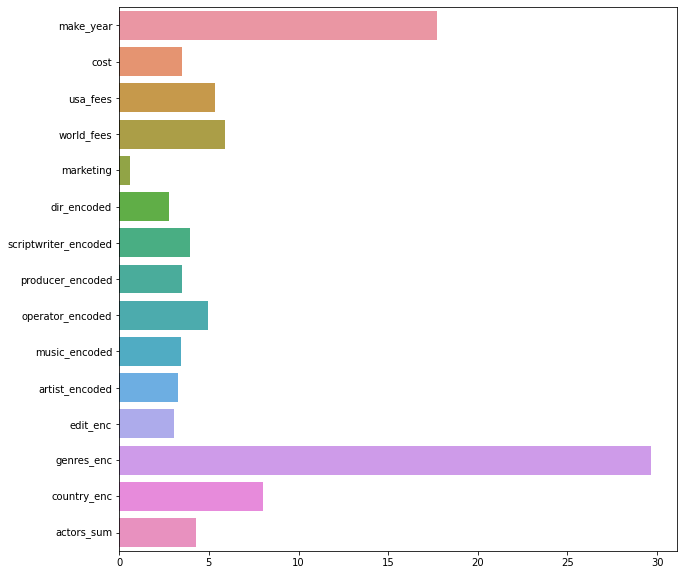

In [330]:
plt.figure(figsize=(10,10))
sns.barplot(x=cat.feature_importances_, y = X_train.columns)

### Идея казалась хорошей...

### Ну а теперь посмотрим, что можно сделать с описанием фильмов

In [332]:
df['synopsis'].head()

0.0    Фотограф Чарльз Касл тяжело переживает утрату ...
1.0    Главные герои отправляются в уникальное место ...
2.0    После сексуальной связи 19-летнюю девушку по и...
3.0    Бен Мейрс, успешный романист, возвращается дом...
4.0    58-летняя разведенная женщина начинает скучать...
Name: synopsis, dtype: object

In [333]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
morph = pymorphy2.MorphAnalyzer()   

def normalize(doc):
    tokens = tokenizer.tokenize(doc)
    tokens = [x.lower() for x in tokens]
    tokens = [x for x in tokens if x not in stopwords.words('russian')]
    tokens = [morph.normal_forms(x)[0] for x in tokens]
    return ','.join(tokens)

In [334]:
df['synopsis_norm'] = df['synopsis'].astype(str).apply(normalize)

In [362]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(norm=None)
matrix = vectorizer.fit_transform(df['synopsis_norm']).todense()
matrix.shape

(4910, 22262)

In [336]:
word_df = pd.DataFrame(
    matrix, 
    columns=vectorizer.get_feature_names()
)

In [337]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(word_df, y, test_size=0.2,
                                                        random_state=42)

poly = PolynomialFeatures(1)
scaler = preprocessing.StandardScaler()
ridge = RidgeCV()
pipe = Pipeline([('poly', poly),('scaler', scaler), ('ridge', ridge)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.99
R2 на тестовом наборе: -0.24
MAE: 0.84
MSE: 1.20


### Сильное переобучение, но все равно не очень плохой результат, можно поудалять очень редкие и слишком частые слова, возможно станет лучше

In [338]:
from sklearn.linear_model import ElasticNetCV

vectorizer = TfidfVectorizer(norm=None, max_df=0.01, min_df=0.005)

word_df = pd.DataFrame(vectorizer.fit_transform(df['synopsis_norm']).todense(),
                       columns=vectorizer.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(word_df, y, test_size=0.2,
                                                        random_state=42)

scaler = preprocessing.StandardScaler()
model = ElasticNetCV(l1_ratio=0.2)
pipe = Pipeline([('scaler', scaler), ('model', model)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.08
R2 на тестовом наборе: 0.02
MAE: 0.73
MSE: 0.95


In [339]:
cat = CatBoostRegressor(max_depth=1)
cat.fit(X_train, y_train, silent=True)
show_metrics(cat, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.09
R2 на тестовом наборе: 0.02
MAE: 0.73
MSE: 0.95


### Кстати, стоит посмотреть насколько наши модели лучше, чем если мы просто проставим всем одинаковое значение (Посмотрим по распределению оценок)

In [340]:
df['imdb_rating'].mean()

6.5178004073319755

In [341]:
np.ones_like(df['imdb_rating']) * 6.5

array([6.5, 6.5, 6.5, ..., 6.5, 6.5, 6.5])

In [342]:
print("MAE: {:.2f}".format(mean_absolute_error(df['imdb_rating'], np.ones_like(df['imdb_rating']) * 6.5)))
print("MSE: {:.2f}".format(mean_squared_error(df['imdb_rating'], np.ones_like(df['imdb_rating']) * 6.5)))

MAE: 0.79
MSE: 1.12


### Перебрав параметры видна сходимость к значению R2 ~ 0.03-0.04.

### Попробуем уменьшить размерность, может нам удастся улучшить точность

In [343]:
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV

vectorizer = TfidfVectorizer(norm=None, max_df=4000, min_df=5)

word_df = pd.DataFrame(vectorizer.fit_transform(df['synopsis_norm']).todense(),
                       columns=vectorizer.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(word_df, y, test_size=0.2,
                                                        random_state=42)

scaler = preprocessing.StandardScaler()
pca = PCA(n_components=100)
model = ElasticNetCV(l1_ratio=0.8)
pipe = Pipeline([('scaler', scaler),('pca', pca), ('model', model)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.06
R2 на тестовом наборе: 0.03
MAE: 0.72
MSE: 0.93


In [344]:
def get_top_n(vectorizer, dataset, n=50):
    sorted_ds = dataset.max(axis=1).sort_values(ascending=False)
    inv_map = {v: k for k, v in vectorizer.vocabulary_.items()}
    names = [inv_map[word_num] if word_num in inv_map else "NOT FOUND" for word_num in sorted_ds[:n].index]
    return dict(zip(names, sorted_ds.values[:n]))

In [345]:
words = get_top_n(vectorizer, word_df)
words

{'план': 43.17988663827119,
 'пересечь': 37.766613584919654,
 'соседка': 35.98323886522599,
 'крутой': 35.50668796620437,
 'летать': 35.07163108125622,
 'бросаться': 34.67141754288854,
 'подпольный': 34.67141754288854,
 'кабаре': 34.30087768211993,
 'культ': 33.95591332468517,
 'обворожительный': 33.633220718997315,
 'почувствовать': 33.33009760991514,
 'сибирский': 32.27355214157911,
 'командир': 30.829893587244758,
 'занятие': 30.829893587244758,
 'упорно': 30.829893587244758,
 'выпивка': 30.829893587244758,
 'книга': 30.829893587244758,
 'сыщик': 30.213290867935726,
 'отдавать': 30.213290867935726,
 'третий': 30.213290867935726,
 'виктория': 30.063578977842624,
 'зависимость': 30.01362652286382,
 'франсуа': 29.679165297437635,
 'погубить': 29.679165297437635,
 'быстро': 29.679165297437635,
 'супермаркет': 29.2080331548121,
 'плод': 29.2080331548121,
 'волшебник': 29.2080331548121,
 'отказ': 29.2080331548121,
 'хроника': 28.786591092180796,
 'вес': 27.73713403431083,
 'пляжный': 27.4

### Если в фильме есть план, то фильм будет хорошим. Но, в целом, сложно сделать какие-то выводы по этим словам.

<AxesSubplot:>

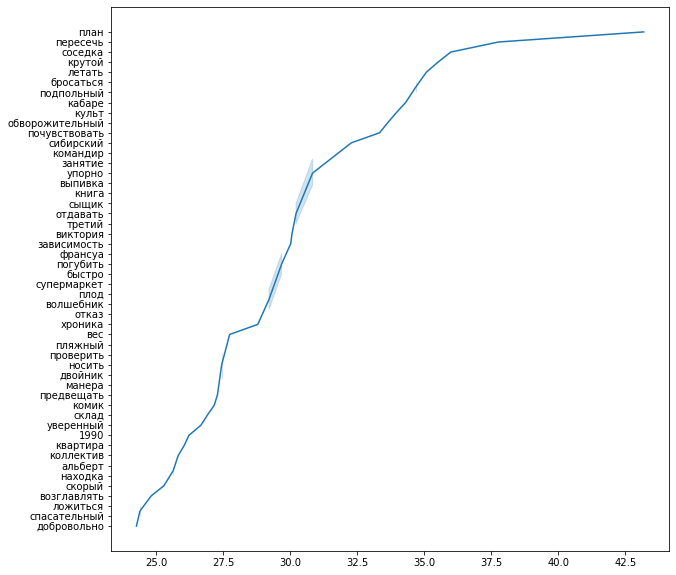

In [346]:
plt.figure(figsize=(10,10))
sns.lineplot(y=words.keys(), x= words.values())

### Не очень удобно, зато подписи видно. Видно что большой разрыв между словами "план" и "пересечь", остальные слова довольно равномерно распределены. 

### В принципе, довольно много хороший фильмов могут содержать слово "план": различные фильмы про ограбление казино/банка (11 друзей Оушена, ограбление по-итальянски и т.д.), так что можно сказать, что наличие данного слова в описании влияет на рейтинг. 
### Слово "соседка", возможно,часто встречается в молодежный комедиях.
### Про слово "крутой" и говорить нечего)
### Забавно, что слова "упорно" и "выпивка" находятся рядом, возможно фильмы о упорных спортсменах и заядлых пьяницах одинаково интересны
### Слова "зависимость" и "погубить" так же могут использоваться в одном контексте
### Попробуем посомтреть на словосочетания.

In [347]:
vectorizer = TfidfVectorizer(norm=None, max_df=1000, min_df=2,ngram_range=(2,2))

word_df = pd.DataFrame(vectorizer.fit_transform(df['synopsis_norm']).todense(),
                       columns=vectorizer.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(word_df, y, test_size=0.2,
                                                        random_state=42)

scaler = preprocessing.StandardScaler()
pca = PCA(n_components=100)
model = ElasticNetCV(l1_ratio=0.9)
pipe = Pipeline([('scaler', scaler),('pca', pca), ('model', model)])
pipe.fit(X_train, y_train)
show_metrics(pipe, X_train, X_test, y_train, y_test)

R2 на обучающем наборе: 0.01
R2 на тестовом наборе: 0.00
MAE: 0.73
MSE: 0.96


<AxesSubplot:>

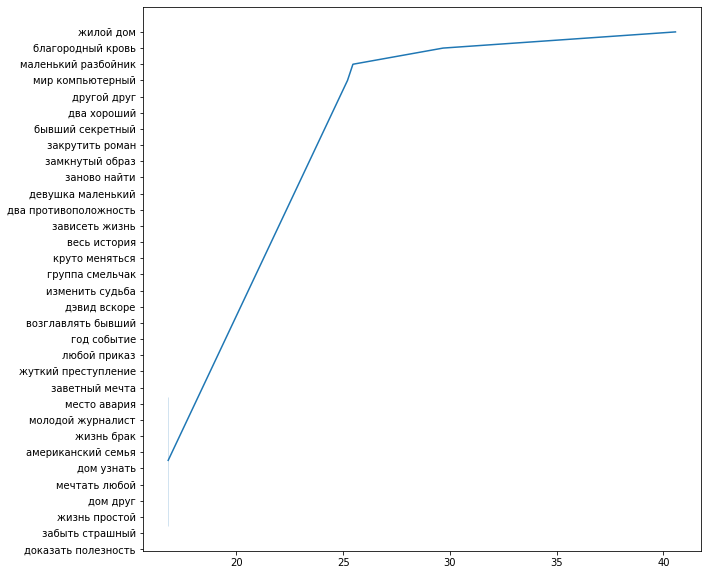

In [348]:
words = get_top_n(vectorizer, word_df)
plt.figure(figsize=(10,10))
sns.lineplot(y=words.keys(), x= words.values())

### А вот это уже интереснее. Тут уже довольно хорошо выделяется темы, например словосочетание "бывший секретный" говорит о каком-то шпионском фильме, "закрутить роман" - это возможно о мелодрамах и т.д.

### Подводя итог, можно сказать что в данном случае, текстовое описание не очень хорошо работает, либо нужно брать другие модели, но TD-IDF, наверное, слишком простая для построения более точной регрессии.  Скорее так можно было бы выделять темы фильмов или определять жанр по описанию.